In [127]:
import os
import sys
import ds_utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

from data.queries import hc_quarter_hour_tz_adjusted, hc_quarter_hour_unadjusted
from process import add_spline

In [128]:
sys.path.insert(0, "/Users/jdelvalle/git/adtech")

## Health Analysis

In [129]:
START_DATE = '20210101'
END_DATE = '20210301'
PRODUCT = 'HEALTH'
TRAFFIC_SOURCE = "MEDIAALPHA"

INFO:root:query: SELECT date_part(DOW, user_ts)::INT AS dayofweek, date_part(... executed in 0.3 seconds
INFO:root:query: SELECT date_part(DOW, utc_ts)::INT AS dayofweek, date_part(H... executed in 0.35 seconds


<AxesSubplot:title={'center':'Revenue Per Session, User Timezone Adjusted via IP'}, xlabel='dayofweek,hourofday'>

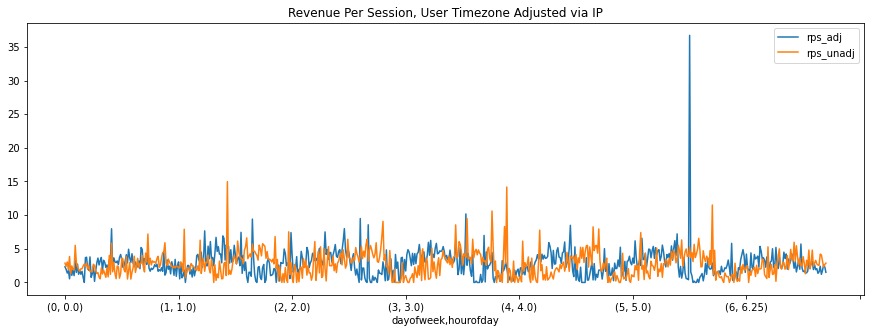

In [130]:
df_tz_adj = hc_quarter_hour_tz_adjusted(start_date=START_DATE, end_date=END_DATE, product=PRODUCT, traffic_source=TRAFFIC_SOURCE)
df_unadj = hc_quarter_hour_unadjusted(start_date=START_DATE, end_date=END_DATE, product=PRODUCT, traffic_source=TRAFFIC_SOURCE)

df_tz_adj.rename(columns={'rps': 'rps_adj'}).merge(
    df_unadj.rename(columns={'rps': 'rps_unadj'}),
    left_index=True,
    right_index=True
)[['rps_adj', 'rps_unadj']].plot(figsize=(15,5), title='Revenue Per Session, User Timezone Adjusted via IP')

In [131]:
quantiles = df_tz_adj['rps'].quantile([.001,.05,.1,.9,.95,.999])

In [132]:
quantiles[0.999]

18.91142930000171

In [133]:
df_tz_adj[15:20]

days_samplesize  sessions  conversions  conv_rate  \
dayofweek hourofday                                                      
0         3.75                     7         2           14        1.0   
          4.00                     5         2           10        1.0   
          4.25                     3         1            3        1.0   
          4.50                     3         2            6        1.0   
          4.75                     4         1            4        1.0   

                     avg_conv_value     rps  int_ix  
dayofweek hourofday                                  
0         3.75               1.6534  1.6534      15  
          4.00               0.7420  0.7420      16  
          4.25               0.0000  0.0000      17  
          4.50               3.6783  3.6783      18  
          4.75               3.7500  3.7500      19

In [134]:
df_tz_adj.loc[df_tz_adj['rps'] > quantiles[0.999], 'rps'] = quantiles[0.999]

In [135]:
df_tz_adj.loc[df_tz_adj['rps'] < quantiles[0.001], 'rps'] = quantiles[0.001]

<AxesSubplot:xlabel='int_ix', ylabel='rps'>

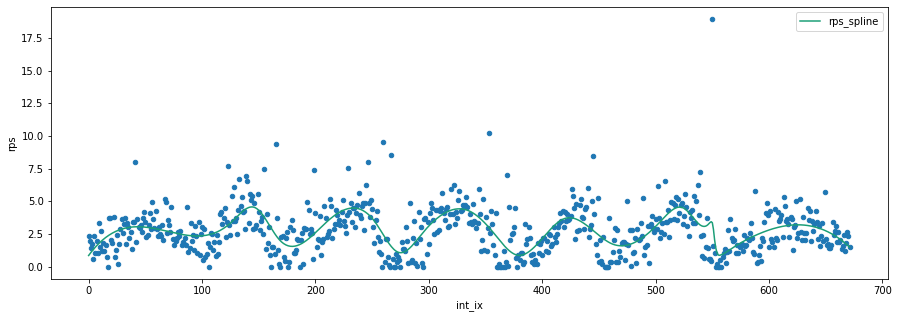

In [136]:
RPS_SPLINE_K = 3
RPS_SPLINE_S =1550

df_tz_adj = add_spline(df_tz_adj, index_col='int_ix', smooth_col='rps', spline_k=RPS_SPLINE_K, spline_s=RPS_SPLINE_S)

ax = df_tz_adj[['rps']].reset_index().plot.scatter(x='int_ix', y='rps')
df_tz_adj[['rps_spline']].plot(ax=ax, figsize=(15,5), colormap='Dark2')

In [137]:
df_tz_adj[15:20]

,dayofweek,hourofday,days_samplesize,sessions,conversions,conv_rate,avg_conv_value,rps,rps_spline
int_ix,,,,,,,,,
15,0,3.75,7,2,14,1.0,1.6534,1.6534,2.219912
16,0,4.00,5,2,10,1.0,0.7420,0.7420,2.284342
17,0,4.25,3,1,3,1.0,0.0000,0.0000,2.345686
18,0,4.50,3,2,6,1.0,3.6783,3.6783,2.404002
19,0,4.75,4,1,4,1.0,3.7500,3.7500,2.459348


<AxesSubplot:xlabel='int_ix', ylabel='sessions'>

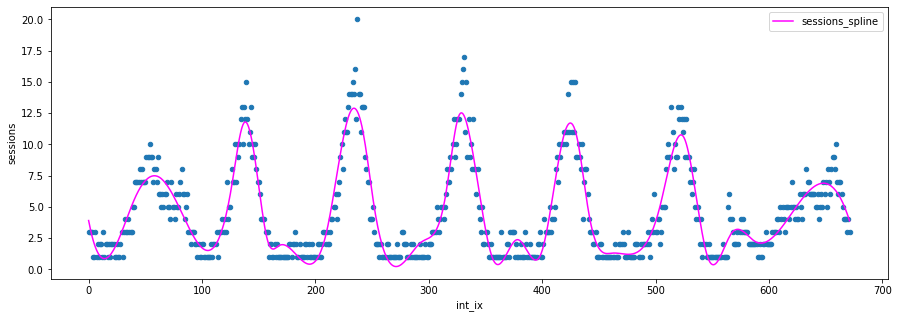

In [138]:
SESSIONS_SPLINE_K = 3
SESSIONS_SPLINE_S = 1000

df_tz_adj = add_spline(df_tz_adj, index_col='int_ix', smooth_col='sessions', spline_k=SESSIONS_SPLINE_K, spline_s=SESSIONS_SPLINE_S)

ax = df_tz_adj[['sessions']].reset_index().plot.scatter(x='int_ix', y='sessions')
df_tz_adj[['sessions_spline']].plot(ax=ax, figsize=(15,5), colormap='spring')

<AxesSubplot:xlabel='int_ix'>

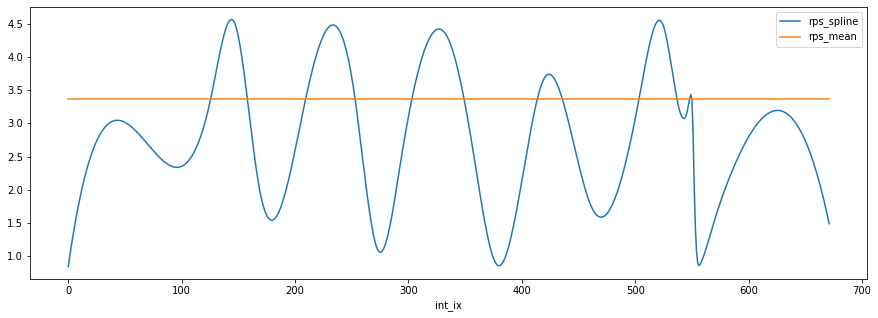

In [139]:
df_tz_adj['rps_mean'] = (df_tz_adj['sessions_spline'] * df_tz_adj['rps_spline']).sum() / df_tz_adj['sessions_spline'].sum()

df_tz_adj[['rps_spline', 'rps_mean']].plot(figsize=(15,5))

In [140]:
df_tz_adj[15:20]

,dayofweek,hourofday,days_samplesize,sessions,conversions,conv_rate,avg_conv_value,rps,rps_spline,sessions_spline,rps_mean
int_ix,,,,,,,,,,,
15,0,3.75,7,2,14,1.0,1.6534,1.6534,2.219912,0.880619,3.369599
16,0,4.00,5,2,10,1.0,0.7420,0.7420,2.284342,0.917280,3.369599
17,0,4.25,3,1,3,1.0,0.0000,0.0000,2.345686,0.976406,3.369599
18,0,4.50,3,2,6,1.0,3.6783,3.6783,2.404002,1.056694,3.369599
19,0,4.75,4,1,4,1.0,3.7500,3.7500,2.459348,1.156840,3.369599


In [141]:
intervals = {}

In [142]:
for day in range(7):
    intervals[day] = []
    for hour in range(0, 96, 1):
        temp_hour = hour / 4
        intervals[day].append((temp_hour, temp_hour + 0.25))

In [143]:
health_set = intervals

In [144]:
df_tz_adj.reset_index(inplace=True)

In [145]:
global_mean = (df_tz_adj['sessions_spline'] * df_tz_adj['rps_spline']).sum() / df_tz_adj['sessions_spline'].sum()

In [146]:
df_tz_adj['baseline'] = 1

In [147]:
df_tz_adj['modifier'] = df_tz_adj['rps_spline'] / global_mean

In [148]:
health_df = df_tz_adj[['int_ix', 'dayofweek', 'hourofday', 'modifier', 'baseline', 'sessions_spline', 'rps_spline', 'rps_mean']]

In [149]:
additional_scales = [0.75, 0.5, 0.25]

def df_generate_scaling(df, col, scales):

    for scale in scales:
        postfix = '_' + str(scale).replace('.', '').lstrip('0')
        df[col + postfix] = ((df[col] - 1.0) * scale) + 1.0
    
    return df

<AxesSubplot:xlabel='int_ix'>

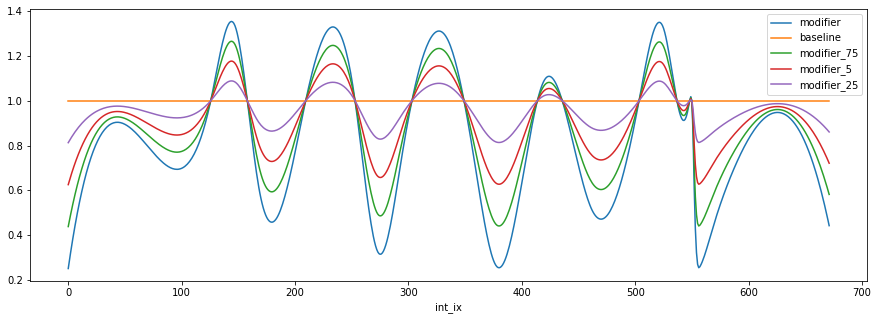

In [150]:
health_scales_df = df_generate_scaling(
    df=health_df[['int_ix', 'dayofweek', 'hourofday', 'modifier', 'baseline']].copy(),
    col='modifier',
    scales=additional_scales
)

health_scales_df[['int_ix', 'modifier', 'baseline', 'modifier_75', 'modifier_5', 'modifier_25']].set_index('int_ix').plot(figsize=(15,5))

In [151]:
health_scales_df['hour_int'] = np.floor(health_scales_df['hourofday']).astype(int)

In [152]:
health_scales_df['modifier'] = ((health_scales_df['modifier'] / 0.05).round() * 0.05).round(2)

**NOTE**: Gotta adapt the day indices for Media Alpha (0-indexed, starting on Monday):

In [154]:
health_scales_df.loc[health_scales_df['dayofweek'] == 0, 'dayofweek'] = 7

In [160]:
health_scales_df['dayofweek'] = health_scales_df['dayofweek'] - 1

In [162]:
health_scales_df = health_scales_df.drop(columns=['int_ix']).sort_values(by=['dayofweek', 'hourofday'])

In [165]:
health_scales_df['int_ix'] = range(len(health_scales_df))

<AxesSubplot:xlabel='int_ix'>

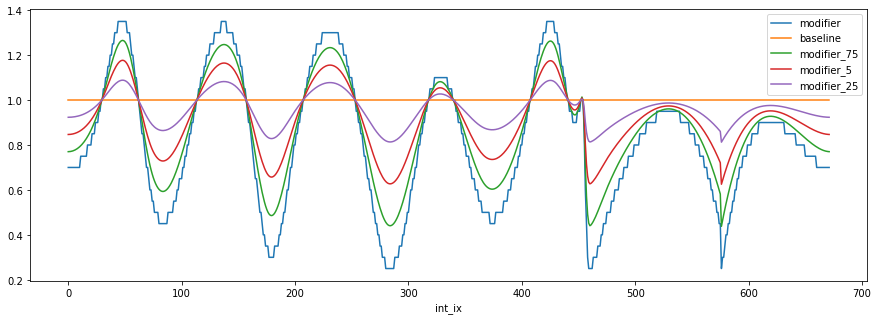

In [166]:
health_scales_df[['int_ix', 'modifier', 'baseline', 'modifier_75', 'modifier_5', 'modifier_25']].set_index('int_ix').plot(figsize=(15,5))

In [167]:
schedule_payload = []

In [168]:
temp_day = []
temp_hour = []

In [169]:
for day in health_scales_df['dayofweek'].unique().tolist():
    for hour in health_scales_df['hour_int'].unique().tolist():
        filt = (health_scales_df['dayofweek'] == day) & (health_scales_df['hour_int'] == hour)
        modifiers = health_scales_df.loc[filt, 'modifier'].tolist()
        temp_day.append(modifiers)
    schedule_payload.append(temp_day)
    temp_day = []

In [170]:
len(schedule_payload)

7

In [171]:
from api.mediaalpha.mediaalpha_client import MediaAlphaAPIClient

In [172]:
token = os.getenv("MEDIAALPHA_TOKEN")

In [173]:
client = MediaAlphaAPIClient(base_url = "https://insurance-api.mediaalpha.com/220", token=token)

In [174]:
# 23898 is a test campaign
r = client.set_time_of_day_modifiers(schedule_payload, campaign = 23898)

# Medicare Analysis

In [248]:
START_DATE = '20210101'
END_DATE = '20210301'
PRODUCT = 'MEDICARE'
TRAFFIC_SOURCE = "MEDIAALPHA"

INFO:root:query: SELECT date_part(DOW, user_ts)::INT AS dayofweek, date_part(... executed in 0.31 seconds
INFO:root:query: SELECT date_part(DOW, utc_ts)::INT AS dayofweek, date_part(H... executed in 0.31 seconds


<AxesSubplot:title={'center':'Revenue Per Session, User Timezone Adjusted via IP'}, xlabel='dayofweek,hourofday'>

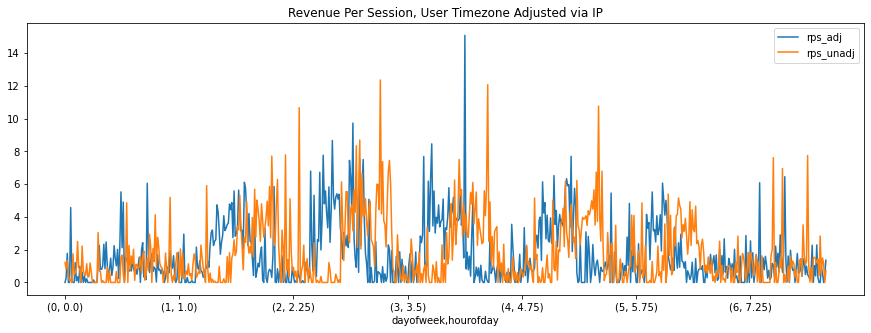

In [249]:
df_tz_adj = hc_quarter_hour_tz_adjusted(start_date=START_DATE, end_date=END_DATE, product=PRODUCT, traffic_source=TRAFFIC_SOURCE)
df_unadj = hc_quarter_hour_unadjusted(start_date=START_DATE, end_date=END_DATE, product=PRODUCT, traffic_source=TRAFFIC_SOURCE)

df_tz_adj.rename(columns={'rps': 'rps_adj'}).merge(
    df_unadj.rename(columns={'rps': 'rps_unadj'}),
    left_index=True,
    right_index=True
)[['rps_adj', 'rps_unadj']].plot(figsize=(15,5), title='Revenue Per Session, User Timezone Adjusted via IP')

In [250]:
quantiles = df_tz_adj['rps'].quantile([.05,.1,.9,.95])

In [251]:
quantiles[0.90]

4.404780000000001

In [252]:
# df_tz_adj.loc[df_tz_adj['interpolated_rps'] > quantiles[0.9], 'interpolated_rps'] = quantiles[0.9]

In [253]:
# df_tz_adj.loc[df_tz_adj['interpolated_rps'] < quantiles[0.1], 'interpolated_rps'] = quantiles[0.1]

<AxesSubplot:xlabel='int_ix', ylabel='rps'>

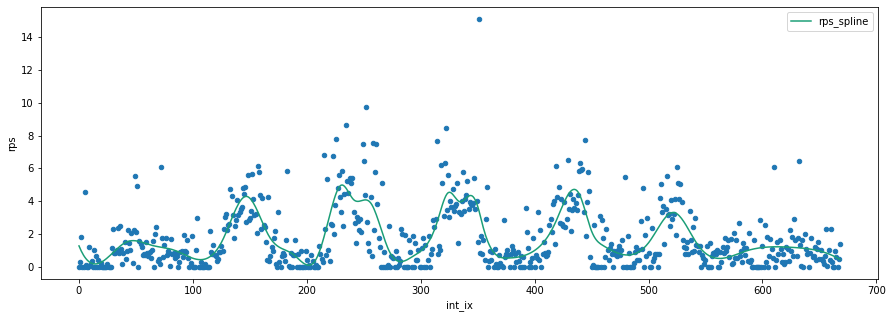

In [254]:
RPS_SPLINE_K = 3
RPS_SPLINE_S = 1200

df_tz_adj = add_spline(df_tz_adj, index_col='int_ix', smooth_col='rps', spline_k=RPS_SPLINE_K, spline_s=RPS_SPLINE_S)

ax = df_tz_adj[['rps']].reset_index().plot.scatter(x='int_ix', y='rps')
df_tz_adj[['rps_spline']].plot(ax=ax, figsize=(15,5), colormap='Dark2')

In [255]:
df_tz_adj.head(5)

,dayofweek,hourofday,days_samplesize,sessions,conversions,conv_rate,avg_conv_value,rps,rps_spline
int_ix,,,,,,,,,
0,0,0.00,2,1,2,1.0,0.0000,0.0000,1.260082
1,0,0.25,4,1,6,1.0,0.2700,0.2700,1.094978
2,0,0.50,2,2,4,1.0,1.7783,1.7783,0.945287
3,0,0.75,2,1,3,1.0,0.0000,0.0000,0.810478
4,0,1.00,2,1,2,1.0,0.0000,0.0000,0.690023


<AxesSubplot:xlabel='int_ix', ylabel='sessions'>

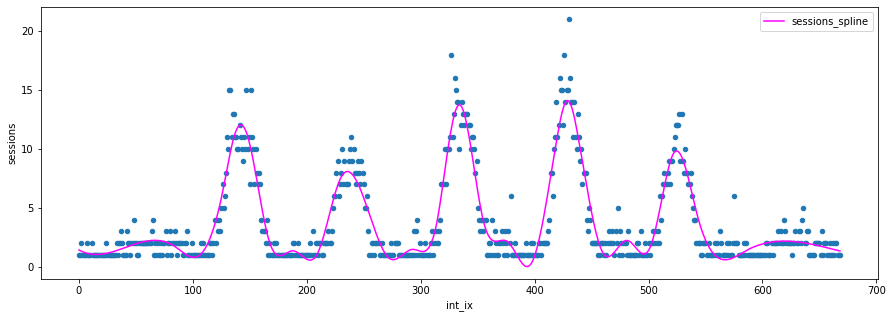

In [256]:
SESSIONS_SPLINE_K = 3
SESSIONS_SPLINE_S = 1100

df_tz_adj = add_spline(df_tz_adj, index_col='int_ix', smooth_col='sessions', spline_k=SESSIONS_SPLINE_K, spline_s=SESSIONS_SPLINE_S)

ax = df_tz_adj[['sessions']].reset_index().plot.scatter(x='int_ix', y='sessions')
df_tz_adj[['sessions_spline']].plot(ax=ax, figsize=(15,5), colormap='spring')

<AxesSubplot:xlabel='int_ix'>

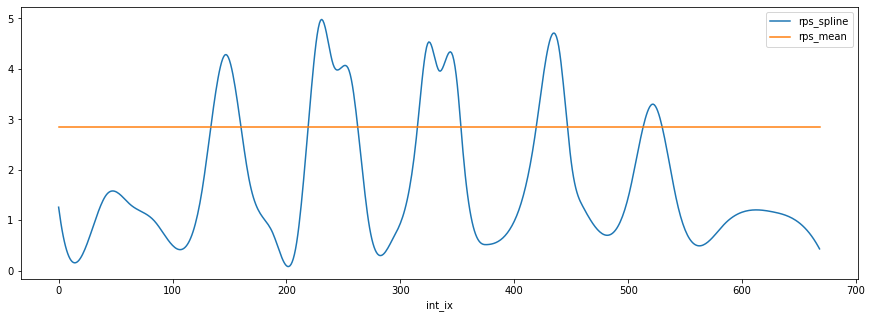

In [257]:
df_tz_adj['rps_mean'] = (df_tz_adj['sessions_spline'] * df_tz_adj['rps_spline']).sum() / df_tz_adj['sessions_spline'].sum()

df_tz_adj[['rps_spline', 'rps_mean']].plot(figsize=(15,5))

In [258]:
intervals = {}

In [259]:
for day in range(7):
    intervals[day] = []
    for hour in range(0, 96, 1):
        temp_hour = hour / 4
        intervals[day].append((temp_hour, temp_hour + 0.25))

In [260]:
medicare_set = intervals

In [261]:
df_tz_adj.reset_index(inplace=True)

In [262]:
medicare_df = df_tz_adj[['int_ix', 'dayofweek', 'hourofday', 'sessions_spline', 'rps_spline', 'rps_mean']]

In [263]:
global_mean = (medicare_df['sessions_spline'] * medicare_df['rps_spline']).sum() / medicare_df['sessions_spline'].sum()

In [264]:
df_tz_adj['baseline'] = 1

In [265]:
df_tz_adj['modifier'] = df_tz_adj['rps_spline'] / global_mean

In [266]:
additional_scales = [0.75, 0.5, 0.25]


def df_generate_scaling(df, col, scales):

    for scale in scales:
        postfix = '_' + str(scale).replace('.', '').lstrip('0')
        df[col + postfix] = ((df[col] - 1.0) * scale) + 1.0
    
    return df

<AxesSubplot:xlabel='int_ix'>

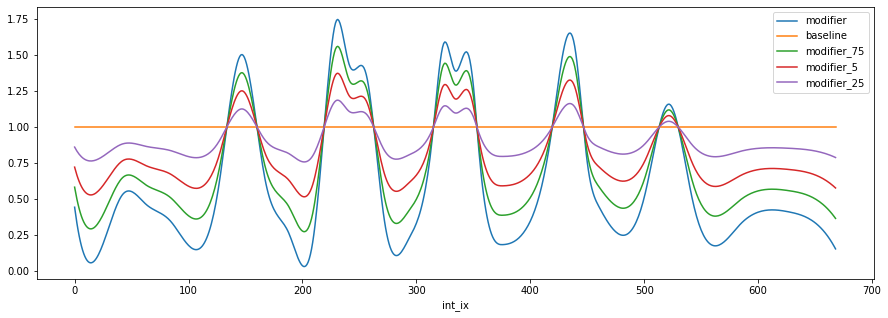

In [267]:
medicare_scales_df = df_generate_scaling(
    df=df_tz_adj[['int_ix', 'dayofweek', 'hourofday', 'modifier', 'baseline']].copy(),
    col='modifier',
    scales=additional_scales
)

medicare_scales_df[['int_ix', 'modifier', 'baseline', 'modifier_75', 'modifier_5', 'modifier_25']].set_index('int_ix').plot(figsize=(15,5))

In [268]:
medicare_scales_df['hour_int'] = np.floor(health_scales_df['hourofday']).astype(int)

In [269]:
medicare_scales_df['modifier'] = ((medicare_scales_df['modifier'] / 0.05).round() * 0.05).round(2)

**NOTE**: We have to convert days of week to MediaAlpha's format (0-indexed starting on Monday):

In [270]:
medicare_scales_df.loc[medicare_scales_df['dayofweek'] == 0, 'dayofweek'] = 7

In [271]:
medicare_scales_df['dayofweek'] = medicare_scales_df['dayofweek'] - 1

In [272]:
medicare_scales_df = medicare_scales_df.drop(columns=['int_ix']).sort_values(by=['dayofweek', 'hourofday'])

In [273]:
medicare_scales_df['int_ix'] = range(len(medicare_scales_df))

<AxesSubplot:xlabel='int_ix'>

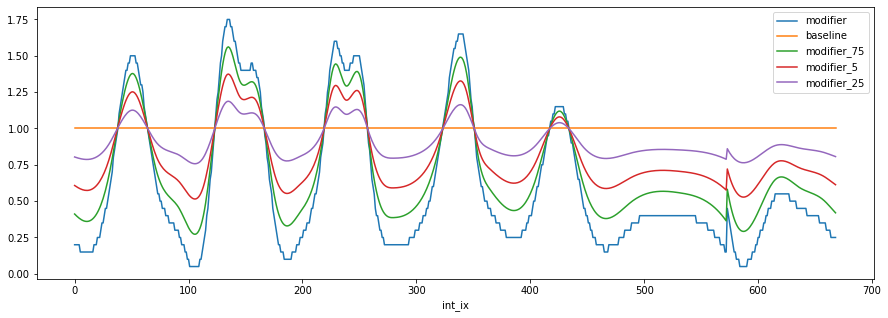

In [274]:
medicare_scales_df[['int_ix', 'modifier', 'baseline', 'modifier_75', 'modifier_5', 'modifier_25']].set_index('int_ix').plot(figsize=(15,5))

In [275]:
schedule_payload = []

In [276]:
temp_day = []
temp_hour = []

In [277]:
for day in health_scales_df['dayofweek'].unique().tolist():
    for hour in health_scales_df['hour_int'].unique().tolist():
        filt = (health_scales_df['dayofweek'] == day) & (health_scales_df['hour_int'] == hour)
        modifiers = health_scales_df.loc[filt, 'modifier'].tolist()
        temp_day.append(modifiers)
    schedule_payload.append(temp_day)
    temp_day = []

In [278]:
len(schedule_payload)

7

In [171]:
from api.mediaalpha.mediaalpha_client import MediaAlphaAPIClient

In [172]:
token = os.getenv("MEDIAALPHA_TOKEN")

In [173]:
client = MediaAlphaAPIClient(base_url = "https://insurance-api.mediaalpha.com/220", token=token)

# FIN

## Get more data (no longer necessary)